<a href="https://colab.research.google.com/github/ayoubfaqraoui/document-fraud-detection-using-deep-learning/blob/main/document_fraud_detection_using_deep_learning_(case_study_of_signature_documents).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy


# Create fake and real folders using rearrange_data function

In [ ]:
import os
import shutil

def rearrange_data(src_path, dest_path):

    os.makedirs(os.path.join(dest_path, 'fake'), exist_ok=True)
    os.makedirs(os.path.join(dest_path, 'real'), exist_ok=True)

    for folder_name in os.listdir(src_path):
        if 'forg' in folder_name:
            shutil.copytree(os.path.join(src_path, folder_name), os.path.join(dest_path, 'fake', folder_name))
        else:
            shutil.copytree(os.path.join(src_path, folder_name), os.path.join(dest_path, 'real', folder_name))


In [ ]:
src_path = '/content/drive/MyDrive/data/train'
dest_path = '/content/drive/MyDrive/data/train_rearranged'
rearrange_data(src_path, dest_path)

In [ ]:
src_path = '/content/drive/MyDrive/data/test'
dest_path = '/content/drive/MyDrive/data/test_rearranged'
rearrange_data(src_path, dest_path)

In [ ]:
img_height = 256
img_width = 256
batch_size = 30

# loading training data

In [ ]:

training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join('/content/drive/MyDrive/data/train_rearranged'),
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1649 files belonging to 2 classes.



# loading testing data

In [ ]:


testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
     os.path.join('/content/drive/MyDrive/data/test_rearranged'),
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 500 files belonging to 2 classes.


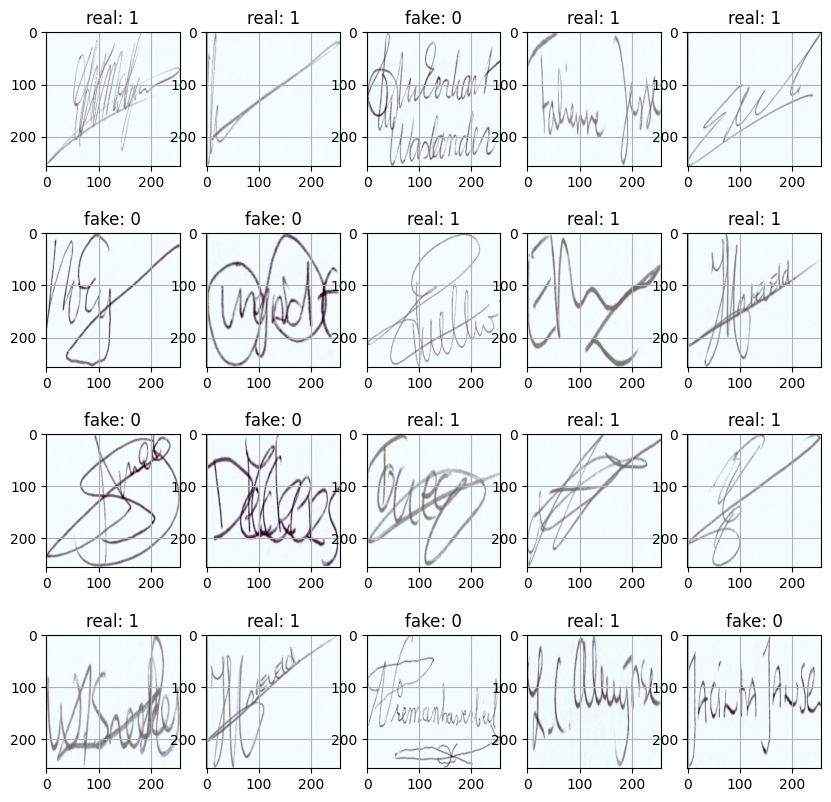

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = training_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{class_names[labels[i]]}: {labels[i]}')
        plt.grid(True)

plt.show()


In [ ]:

training_ds = training_ds.cache()
testing_ds = testing_ds.cache()

buffer_size = tf.data.experimental.AUTOTUNE
training_ds = training_ds.prefetch(buffer_size)
testing_ds = testing_ds.prefetch(buffer_size)

# The Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class_names = ['fake', 'real']

# Define the model
MyModel = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.AveragePooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.AveragePooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(512, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='sigmoid')
])

# Compile the model
MyModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model
MyModel.build(input_shape=(None, img_height, img_width, 3))

# Display the model summary
MyModel.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 127, 127, 32)     0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       7

# Compile the model with Adam optimizer and sparse categorical crossentropy loss

In [ ]:

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
MyModel.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Train the model on the training dataset for 5 epochs and store the results

In [ ]:

history = MyModel.fit(training_ds, validation_data=testing_ds, epochs=5)
history_dict = history.history

Epoch 1/5
55/55 [==============================] - 267s 5s/step - loss: 0.6926 - accuracy: 0.5240 - val_loss: 0.7095 - val_accuracy: 0.5040
Epoch 2/5
55/55 [==============================] - 4s 70ms/step - loss: 0.6920 - accuracy: 0.5143 - val_loss: 0.6960 - val_accuracy: 0.5040
Epoch 3/5
55/55 [==============================] - 4s 68ms/step - loss: 0.6835 - accuracy: 0.5737 - val_loss: 0.6219 - val_accuracy: 0.6360
Epoch 4/5
55/55 [==============================] - 4s 68ms/step - loss: 0.4454 - accuracy: 0.8017 - val_loss: 0.1575 - val_accuracy: 0.9520
Epoch 5/5
55/55 [==============================] - 4s 69ms/step - loss: 0.2417 - accuracy: 0.9145 - val_loss: 0.1167 - val_accuracy: 0.9680


# Plot the training and testing accuracy over time

Text(0.5, 1.0, 'Training and Testing Accuracy over Epochs')

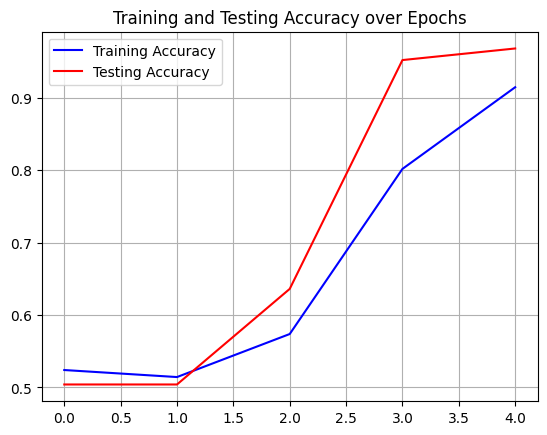

In [ ]:

plt.plot(history_dict['accuracy'], color='blue', label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], color='red', label='Testing Accuracy')
plt.grid(True)
plt.legend()
plt.title('Training and Testing Accuracy over Epochs')

# Plot the training and testing loss over time

Text(0.5, 1.0, 'Training and Testing Loss over Epochs')

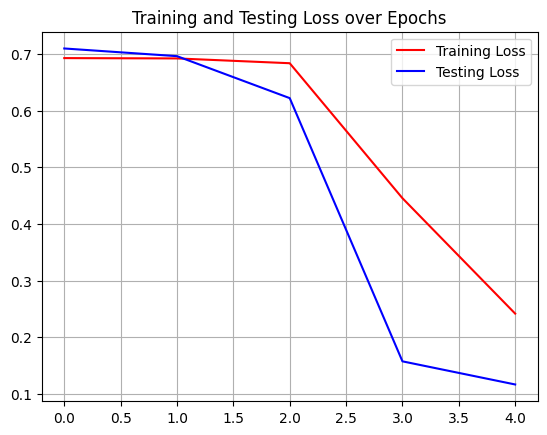

In [ ]:

plt.plot(history_dict['loss'], color='red', label='Training Loss')
plt.plot(history_dict['val_loss'], color='blue', label='Testing Loss')
plt.grid(True)
plt.legend()
plt.title('Training and Testing Loss over Epochs')

# Display the image and the predicted label

In [ ]:
tf.keras.models.save_model(MyModel,'/content/drive/MyDrive/detection_of_forge_document/my_model.h5')

In [ ]:
MyModel = tf.keras.models.load_model('/content/drive/MyDrive/detection_of_forge_document/my_model.h5')

Enter the path of the image you want to test: /content/drive/MyDrive/data/test_rearranged/real/065/02_065.png
1/1 [==============================] - 0s 22ms/step


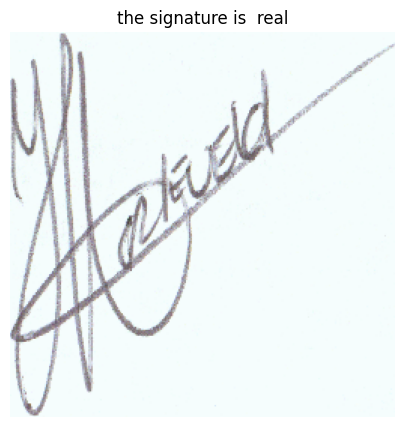

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Set the figure size
plt.figure(figsize=(5, 5))

# Load the image
img_path = input("Enter the path of the image you want to test: ")
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = MyModel.predict(img_array)
pred_label = class_names[np.argmax(predictions)]

plt.imshow(img)
plt.title(f"the signature is  {pred_label}")
plt.axis('off')
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

MyModel.save('/content/drive/MyDrive/forge_real_signature_model/signature_model.hdf5')